In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys # to use your own functions
import io


import csv

import nltk
from nltk.collocations import *

import networkx as nx

import matplotlib.pyplot as plt

# There is a lot of changes in Plotly nowadays. Perhaps some modifications of the code will be needed at some point
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### google drive
from google.colab import drive

!pip install sddk # our own package for working with sciencedata.dk
from  sddk import * # import all functions

In [2]:
conf = configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [0]:
# authorize and mount google drive
drive.mount('/content/gdrive')
gdrive_root = "/content/gdrive/My Drive/a_PROJECTS/DiRECT-rep/big-gods-greek/" ### to be modified according to the user's gdrive structure

### to set gdrive_root as a folder to look at our own functions and modules
sys.path.append(gdrive_root)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/12wOBjRGgoBSIXoN_9cbG32eKA8UAWwWB9YCvpb8xFnU/edit?usp=sharing")

# Manual coding of some proxies

In [0]:
### manually coded data from Morris' book
morris_proxies = pd.read_csv(gdrive_root + "data/proxies/morris-dataset-extracted.csv")[:13]
ober_dev_index = pd.read_csv(gdrive_root + "data/proxies/ober_development-index.csv")
house_size = [51, 49, 70, 149, 230]
morris_proxies.head(5)

,century,kcalpercap,biggestsettlsize
0,-8,21000,75000
1,-7,21500,100000
2,-6,22000,125000
3,-5,23000,150000
4,-4,24000,150000


In [0]:
cent_source = morris_proxies["century"].to_numpy()
cent_source = list(cent_source + 0.5)[0:-1]
cent_source

NameError: ignored

In [0]:
morris_proxies.at[0, "kcalpercap"]

21000

In [0]:
house_size

[51, 49, 70, 149, 230]

In [0]:
### transforming from years (e.g. "-2" in the original data means "200BC") to centuries (e.g. -1.5) 

proxies_cleaned = []
for i in range(0, 12):
  try: devindex_orig = ober_dev_index.at[i, "index_val"]
  except: devindex_orig = None
  try: proxies_cleaned.append([morris_proxies.at[i, "century"], morris_proxies.at[i, "kcalpercap"], morris_proxies.at[i, "biggestsettlsize"], devindex_orig])
  except: proxies_cleaned.append([None, None, None, None, None])
  cent = morris_proxies.at[i, "century"] + 0.5
  kcal = (morris_proxies.at[i, "kcalpercap"] + morris_proxies.at[i+1, "kcalpercap"])/2
  settl = (morris_proxies.at[i, "biggestsettlsize"] + morris_proxies.at[i+1, "biggestsettlsize"]) /2
  try: devindex = (ober_dev_index.at[i, "index_val"] + ober_dev_index.at[i + 1, "index_val"]) / 2
  except: devindex = None
  proxies_cleaned.append([cent, kcal, settl, devindex,])

proxies_cleaned_df = pd.DataFrame(proxies_cleaned, columns= ["date_avr", "kcal", "settl", "devindex"])
proxies_cleaned_df

,date_avr,kcal,settl,devindex
0,-8.0,21000.0,75000.0,0.90
1,-7.5,21250.0,87500.0,1.30
2,-7.0,21500.0,100000.0,1.70
3,-6.5,21750.0,112500.0,2.50
4,-6.0,22000.0,125000.0,3.30
5,-5.5,22500.0,137500.0,4.25
6,-5.0,23000.0,150000.0,5.20
7,-4.5,23500.0,150000.0,6.35
8,-4.0,24000.0,150000.0,7.50
9,-3.5,25000.0,150000.0,8.25


# Extrapolation of the DevIndex by bone findings

In [0]:
### extrapolation of the development index from Ober

### we will use data on bones as a proxy for living standards in the Roman Empire: Jongman, Willem M., ‘The Early Roman Empire: Consumption’, in Cambridge Economic History of the Greco-Roman World, ed. by Walter Scheidel, Ian Morris, and Richard P. Saller (Cambridge: Cambridge University Press, 2007), pp. 592–618

bones_1ce = 200000
bones_2ce = 260000
bones_3ce = 175000
bones_4ce = 165000
bones = [bones_1ce, bones_2ce, bones_3ce, bones_4ce]
bones


[200000, 260000, 175000, 165000]

In [0]:
### we can say conservatively claim, that the living standards in RE was still worse than the living standards in Greece
### therefore, we can say that the peak of Roman performance will be at best in between the two best centuries of the Greece.
rome_2ce = (8.25 + 6.35) / 2 
rome_2ce

7.3

In [0]:
### this value corresponds to 260000 bones.
# thus, we will use the ratio between bones from other centuries to the ratio of bones from the 3rd century to extrapolate the developmental index 
rome_1ce = np.round(rome_2ce * (bones_1ce / bones_2ce), 2)
rome_3ce = np.round(rome_2ce * (bones_3ce / bones_2ce), 2)
rome_4ce = np.round(rome_2ce * (bones_4ce / bones_2ce), 2)

dev_extra_raw = [rome_1ce, rome_2ce, rome_3ce, rome_4ce]
dev_extra_raw

[5.62, 7.3, 4.91, 4.63]

In [0]:
half_cents = [num/10 for num in range(5, 40, 5)]
half_cents

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

In [0]:
dev_extra = []
for i in  range(len(dev_extra_raw)):
  dev_extra.append(dev_extra_raw[i])
  try: dev_extra.append((dev_extra_raw[i] + dev_extra_raw[i+1]) / 2) 
  except: break
dev_extra ### let's assume there was not a rapid fall anymore
dev_extra

[5.62, 6.46, 7.3, 6.105, 4.91, 4.77, 4.63]

In [0]:
devextra = pd.DataFrame([half_cents, dev_extra]).T
devextra.columns = ["date_avr", "devrome"]
devextra

,date_avr,devrome
0,0.5,5.620
1,1.0,6.460
2,1.5,7.300
3,2.0,6.105
4,2.5,4.910
5,3.0,4.770
6,3.5,4.630


In [0]:
proxies = pd.merge(proxies_cleaned_df, devextra, on="date_avr", how="outer")
proxies

,date_avr,kcal,settl,devindex,devrome
0,-8.0,21000.0,75000.0,0.90,NaN
1,-7.5,21250.0,87500.0,1.30,NaN
2,-7.0,21500.0,100000.0,1.70,NaN
3,-6.5,21750.0,112500.0,2.50,NaN
4,-6.0,22000.0,125000.0,3.30,NaN
5,-5.5,22500.0,137500.0,4.25,NaN
6,-5.0,23000.0,150000.0,5.20,NaN
7,-4.5,23500.0,150000.0,6.35,NaN
8,-4.0,24000.0,150000.0,7.50,NaN
9,-3.5,25000.0,150000.0,8.25,NaN


In [0]:
### exporting the data (for manual coding)
set_with_dataframe(sh.add_worksheet("proxies_new", rows=1, cols=1), proxies)

In [0]:
### uploading the data back
proxies = get_as_dataframe(sh.worksheet("proxies_new"))
proxies

,date_avr,kcal,settl,devindex,devextra,period
0,-8.0,21000,75000,0.90,0.900,archaic
1,-7.5,21250,87500,1.30,1.300,archaic
2,-7.0,21500,100000,1.70,1.700,archaic
3,-6.5,21750,112500,2.50,2.500,archaic
4,-6.0,22000,125000,3.30,3.300,archaic
5,-5.5,22500,137500,4.25,4.250,archaic
6,-5.0,23000,150000,5.20,5.200,classical
7,-4.5,23500,150000,6.35,6.350,classical
8,-4.0,24000,150000,7.50,7.500,classical
9,-3.5,25000,150000,8.25,8.250,classical


In [0]:
proxies.to_csv("proxies.csv")

In [0]:
from google.colab import files
files.download("proxies.csv")

In [0]:
write_file("SDAM_data/OGL/proxies.json", proxies, conf)


Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/OGL/proxies.json"


In [0]:
### ESTABLISH CONNECTION WITH THE SPREADSHEET WITH RESULTS

gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1aRNUQeci2aWApkXk69OI_9YINL8YXXnornKkVi0LZeE/edit?usp=sharing")

In [0]:
### export to results
set_with_dataframe(sh.add_worksheet("proxies_all", rows=1, cols=1), proxies)

# Start with complete proxy data

In [10]:
proxies = read_file("SDAM_data/OGL/proxies.json", "df", conf)[1:]
proxies.set_index("date_avr", inplace=True)
proxies

,kcal,settl,devindex,devextra,period
date_avr,,,,,
-7.5,21250,87500,1.30,1.300,archaic
-7.0,21500,100000,1.70,1.700,archaic
-6.5,21750,112500,2.50,2.500,archaic
-6.0,22000,125000,3.30,3.300,archaic
-5.5,22500,137500,4.25,4.250,archaic
-5.0,23000,150000,5.20,5.200,classical
-4.5,23500,150000,6.35,6.350,classical
-4.0,24000,150000,7.50,7.500,classical
-3.5,25000,150000,8.25,8.250,classical


In [0]:
%%capture
### plotting with latex
### in google colab it is quite complex configuration
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
### most latex documents have a textwidth of 345 pt
width_pixels = 345
inches_per_pt = 1 / 72.27
width_inches = round(width_pixels * inches_per_pt, 4)
height_inches = round(width_inches * ((5**.5 - 1) / 4), 4)
print(width_inches, height_inches)

4.7738 1.4752


In [67]:
plt.style.available

['classic',
 'seaborn-bright',
 'seaborn-white',
 'fivethirtyeight',
 'grayscale',
 'tableau-colorblind10',
 'seaborn-whitegrid',
 'seaborn-dark-palette',
 'seaborn-talk',
 '_classic_test',
 'seaborn-muted',
 'Solarize_Light2',
 'seaborn-paper',
 'fast',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-dark',
 'dark_background',
 'seaborn',
 'bmh',
 'seaborn-pastel',
 'seaborn-deep',
 'seaborn-poster',
 'seaborn-notebook',
 'seaborn-ticks',
 'seaborn-darkgrid']

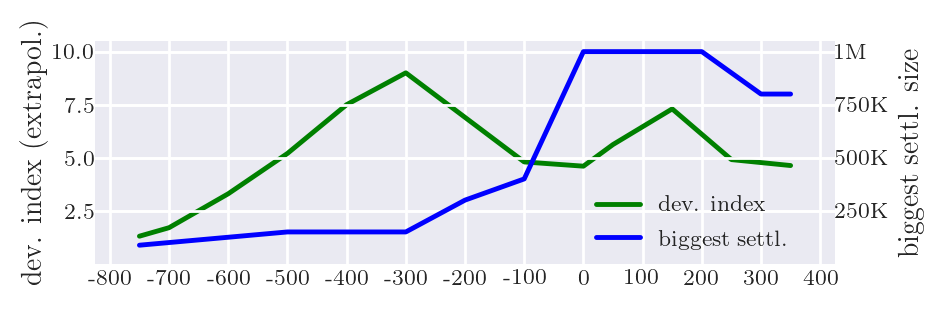

In [75]:
xticks = [value for value in range(-8, 5)]
xticklabels = [value for value in range(-800, 600, 100)]

# Using seaborn's style
mpl.rcParams['text.usetex']=True
plt.style.use('seaborn')
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}
mpl.rcParams.update(nice_fonts)
mpl.rcParams['xtick.major.pad']='2'
mpl.rcParams['ytick.major.pad']='0'

fig, ax1 = plt.subplots(1, 1, figsize=(width_inches, height_inches), dpi = 200)

plt.setp(ax1, xlim=[-8.25, 4.25], xticks=xticks, xticklabels=xticklabels)

ax1.plot(proxies["devextra"], color="green", label="dev. index")
#ax1.set_title("dev. index")
ax1.set_ylabel("dev. index (extrapol.)", labelpad=2)
ax1.set_ylim(0,10.5)
ax1.set_yticks([2.5, 5, 7.5, 10])
#ax1.set_yticklabels(["2.", ".01"])

ax2 = ax1.twinx()

ax2.plot(proxies["settl"], color="blue", label="biggest settl.")
#ax2.set_title("biggest settl.")
ax2.set_ylabel("biggest settl. size")
ax2.set_ylim(0, 1050000)
ax2.set_yticks([250000, 500000, 750000, 1000000])
ax2.set_yticklabels(["250K", "500K", "750K", "1M"])


ax1_leg = ax1.get_legend_handles_labels()
ax2_leg = ax2.get_legend_handles_labels()
plt.legend(list(ax1_leg[0]) + list(ax2_leg[0]), ("dev. index", "biggest settl."), bbox_to_anchor=(0.65, 0.4))

plt.show()

fig.savefig("proxies-by-date.eps", bbox_inches="tight")

In [0]:
from google.colab import files
files.download("proxies-by-date.eps")